In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.integrate import odeint
from numba import njit

from rodeo.jax.ibm_init import ibm_init
from rodeo.jax.ibm_bridge_init import ibm_bridge_init
from rodeo.jax.ode_solve import *
import rodeo.jax.ode_bridge_solve as bsol

from jax.config import config
config.update("jax_enable_x64", True)

def ode_fun_jax(X_t, t, theta):
    "FitzHugh-Nagumo ODE."
    a, b, c = theta
    V, R = X_t[:,0]
    return jnp.array([[c*(V - V*V*V/3 + R)],
                    [-1/c*(V - a + b*R)]])


In [2]:
# problem setup and intialization
n_deriv = 1  # Total state
n_obs = 2  # Total measures
n_deriv_prior = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 100
tmin = 0.
tmax = 2.
theta = np.array([0.2, 0.2, 3])
thetaj = jnp.array(theta)

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = 10e-1
sigma = jnp.array([sigma]*n_obs)

# Initial value, x0, for the IVP
W_mat = np.zeros((n_obs, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W_block = jnp.array(W_mat)

# Initial x0 for odeint
ode0 = np.array([-1., 1.])

# Initial x0 for jax block
#x0_block = jnp.array([[-1., 1., 1.], [1., 1/3, -0.3555555555555555]])
x0_block = jnp.array([[-1., 1., 0.], [1., 1/3, 0.]])


# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
n_order = jnp.array([n_deriv_prior]*n_obs)
ode_init = ibm_init(dt, n_order, sigma)

key = jax.random.PRNGKey(0)
sim_jit = jax.jit(solve_sim, static_argnums=(1, 6))
sim1 = sim_jit(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=thetaj,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **ode_init)

In [3]:
def fitz0(X_t, t, theta):
    a, b, c = theta
    V, R = X_t
    return np.array([c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)])

In [4]:
from scipy.integrate import odeint
import numpy as np
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(fitz0, ode0, tseq, args=(theta,))
der = jnp.array([fitz0(exact[t],tseq[t],theta) for t in range(n_eval+1)])

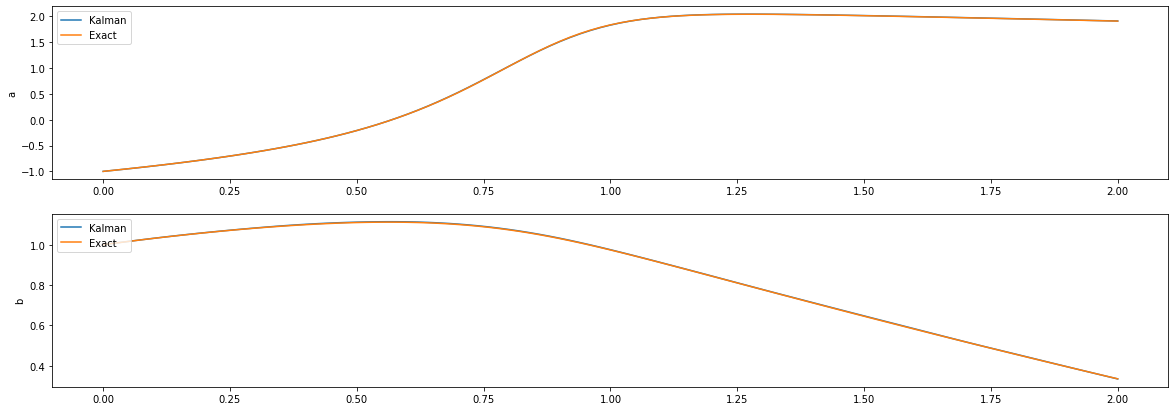

In [5]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_obs):
    axs[i].plot(tseq,sim1[:,i, 0], label="Kalman")
    #axs[i].plot(tseq, knum_sim[:, n_deriv_prior[0]*i], label="Kalman2")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [110]:
def ibm_bridge_init(n_res, dt, n_order, sigma, Y, W, Omega):
    n_block = len(n_order)
    init = jax.vmap(lambda r: ibm_init(r*dt, n_order, sigma))(jnp.arange(max(2, n_res)))
    Y = jnp.repeat(Y[:, jnp.newaxis, :, :], n_res, axis=1)
    A, Q, R = bridge_pars(W, init, Omega, n_res, n_block)
    init = bridge_prior(A, Q, R, Y, n_res, n_block)
    
    return init

In [17]:
n_block = len(n_order)
init = jax.vmap(lambda r: ibm_init(r*dt, n_order, sigma))(jnp.arange(max(2, n_res)))
Y = jnp.reshape(der[1::n_res], newshape=(-1, 2, 1))
Y = jnp.repeat(Y[:, jnp.newaxis, :, :], n_res, axis=1)
A, Q, R = bridge_pars(W_block, init, Omega, n_res, n_block)

In [18]:
Qt = init['wgt_state']
Rt = init['var_state']
b=1
r=0
y_dim = Omega.shape[1]
eye = jnp.eye(y_dim)
WQ2 = jnp.matmul(W_block[b], Qt[r, b])
AS_X = jnp.matmul(WQ2, Rt[1, b])
mu_X = jnp.matmul(WQ2, Qt[1, b])
Sigma_y = (
    jnp.matmul(AS_X, WQ2.T) + 
    jnp.linalg.multi_dot([W_block[b], Rt[r, b], W_block[b].T]) +
    Omega[b])
Sigma_yinv = _solveV(Sigma_y, eye)
An = jnp.matmul(AS_X.T, Sigma_yinv)
Rn = Rt[1,b] - jnp.matmul(An, AS_X)

In [111]:
def bridge_prior(A, Q, R, Y, n_res, n_block):
    n_eval = Y.shape[0]
    mu_state = jax.vmap(lambda t:
                jax.vmap(lambda r: 
                jax.vmap(lambda b: jnp.matmul(A[r, b], Y[t, r, b]))
                        (jnp.arange(n_block)))(jnp.arange(n_res)))(jnp.arange(n_eval))
    mu_state = jnp.reshape(mu_state, newshape=(n_eval*n_res, n_block, -1))
    wgt_state = jnp.tile(Q.T, n_eval).T
    var_state = jnp.tile(R.T, n_eval).T
    
    init = {"wgt_state": wgt_state, "mu_state": mu_state, "var_state": var_state}
    return init

In [112]:
from rodeo.jax.kalmantv import _solveV
def bridge_pars(W, bridge_init, Omega, n_res, n_block):
    Qt = bridge_init['wgt_state']
    Rt = bridge_init['var_state']
    #Q0 = Qt[0] # <- need to iterate (Q_2)
    #R0 = Rt[0] # <- need to iterate (R_2)
    Q1 = Qt[1] # <- constant (Q_1)
    R1 = Rt[1] # <- constant (R_1)
    y_dim = Omega.shape[1]
    eye = jnp.eye(y_dim)
    
    def vmap_res(r):
        def vmap_block(b):
            WQ2 = jnp.matmul(W[b], Qt[r, b])
            AS_X = jnp.matmul(WQ2, R1[b])
            mu_X = jnp.matmul(WQ2, Q1[b])
            Sigma_y = (
                jnp.matmul(AS_X, WQ2.T) + 
                jnp.linalg.multi_dot([W[b], Rt[r, b], W[b].T]) +
                Omega[b])
            Sigma_yinv = _solveV(Sigma_y, eye)
            An = jnp.matmul(AS_X.T, Sigma_yinv)
            Qn = Q1[b] - jnp.matmul(An, mu_X)
            Rn = R1[b] - jnp.matmul(An, AS_X)

            return An, Qn, Rn
        return jax.vmap(lambda b: vmap_block(b))(jnp.arange(n_block))
    A, Q, R = jax.vmap(lambda r: vmap_res(r))(jnp.arange(n_res)[::-1])
    
    return A, Q, R
    

In [10]:
n_res = 2
Omega = 0.00001*jnp.ones((2,1,1))
Y = jnp.reshape(exact[n_res::n_res], newshape=(-1, 2, 1))
WW = jnp.array([[[1., 0., 0.]], [[1., 0., 0.]]])
bridge_init = ibm_bridge_init(n_res, dt, n_order, sigma, Y, WW, Omega)

In [11]:
key = jax.random.PRNGKey(0)
sim_jit2 = jax.jit(bsol.solve_mv, static_argnums=(1, 6))
sim2, _ = sim_jit2(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=thetaj,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **bridge_init)

In [58]:
mu_state_next = scan_out['state_filt'][0][-1]
var_state_next = scan_out['state_filt'][1][-1]
wgt_state = bridge_init['wgt_state'][-2]
mu_state_filt = scan_out['state_filt'][0][-2]
var_state_filt = scan_out['state_filt'][1][-2]
mu_state_pred = scan_out['state_pred'][0][-1]
var_state_pred = scan_out['state_pred'][1][-1]
n_block=2
mu_state_curr, var_state_curr = jax.vmap(lambda b:
    smooth_mv(
        mu_state_next=mu_state_next[b],
        var_state_next=var_state_next[b],
        wgt_state=wgt_state[b],
        mu_state_filt=mu_state_filt[b],
        var_state_filt=var_state_filt[b],
        mu_state_pred=mu_state_pred[b],
        var_state_pred=var_state_pred[b],
    )
)(jnp.arange(n_block))

In [199]:
from rodeo.jax.kalmantv import _smooth, _solveV
var_state_temp, var_state_temp_tilde = _smooth(
    var_state_filt[0], var_state_pred[0], wgt_state[0]
)

var_state_temp = var_state_filt[0].dot(wgt_state[0].T)
var_state_temp_tilde = _solveV(var_state_pred[0], var_state_temp.T).T

In [217]:
var_state = bridge_init['var_state'][-2]
jnp.linalg.inv(jnp.linalg.multi_dot(
        [wgt_state[0], b, wgt_state[0].T]) + var_state[0])

DeviceArray([[        inf,         nan,         nan],
             [ 0.        ,  2.06436103, -0.64761975],
             [-0.        , -0.64761975,  0.20319854]], dtype=float64)

In [202]:
jnp.linalg.inv(var_state_pred[0])

DeviceArray([[         inf,          nan,          nan],
             [  0.        , 293.8387619 , -58.09753153],
             [ -0.        , -58.09753153,  12.02769531]], dtype=float64)

In [59]:
from rodeo.jax.ode_bridge_solve import _solve_filter

scan_out = _solve_filter(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=thetaj,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **bridge_init)


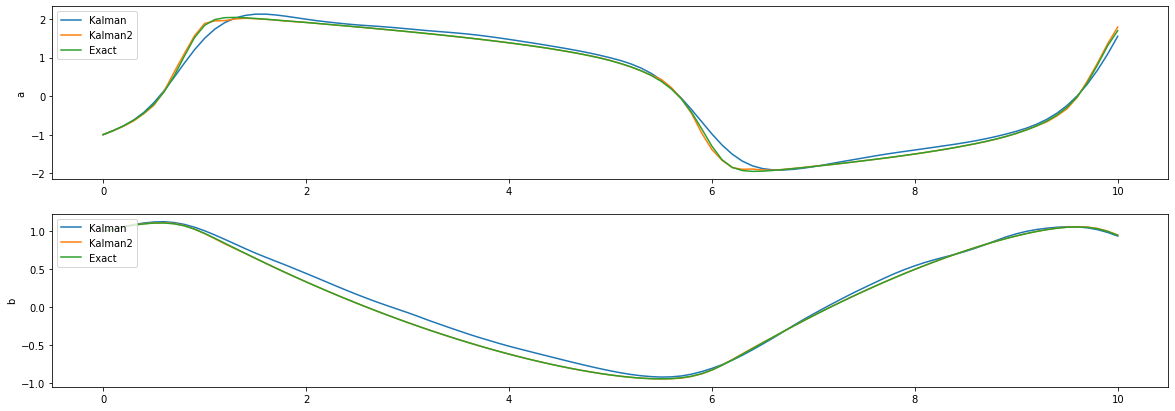

In [12]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_obs):
    axs[i].plot(tseq,sim1[:,i, 0], label="Kalman")
    axs[i].plot(tseq,sim2[:,i, 0], label="Kalman2")
    #axs[i].plot(tseq,sim3[:,i, 0], label="Kalman3")
    #axs[i].plot(tseq, knum_sim[:, n_deriv_prior[0]*i], label="Kalman2")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [22]:
import unittest
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from rodeo.jax.ibm_init import ibm_init
from rodeo.utils.utils import zero_pad
from scipy.integrate import odeint

# ode function used by jax
def ode_fun_jax(X_t, t, theta):
    "SEIRAH ODE function"
    p = len(X_t)//6
    S, E, I, R, A, H = X_t[:, 0]
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q= theta
    D_h = 30
    x1 = -b*S*(I + alpha*A)/N
    x2 = b*S*(I + alpha*A)/N - E/D_e
    x3 = r*E/D_e - I/D_q - I/D_I
    x4 = (I + A)/D_I + H/D_h
    x5 = (1-r)*E/D_e - A/D_I
    x6 = I/D_q - H/D_h
    return jnp.array([[x1], [x2], [x3], [x4], [x5], [x6]])

def ode_fun2(X_t, t, theta, out=None):
    "SEIRAH ODE function"
    S, E, I, R, A, H = X_t
    N = S + E + I + R + A + H
    b, r, alpha, D_e, D_I, D_q = theta
    D_h = 30
    dS = -b*S*(I + alpha*A)/N
    dE = b*S*(I + alpha*A)/N - E/D_e
    dI = r*E/D_e - I/D_q - I/D_I
    dR = (I + A)/D_I + H/D_h
    dA = (1-r)*E/D_e - A/D_I
    dH = I/D_q - H/D_h
    out = np.array([dS, dE, dI, dR, dA, dH])
    return out

In [31]:
# problem setup and intialization
n_deriv = 1  # Total state
n_obs = 6  # Total measures
n_deriv_prior = 3

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 50
tmin = 0.
tmax = 10.
theta = np.array([2.23, 0.034, 0.55, 5.1, 2.3, 0.36])

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 6
sigma = 10e-10


# Initial value, x0, for the IVP
W_mat = np.zeros((n_obs, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W_block = jnp.array(W_mat)

ode0 = np.array([63804435, 15492, 21752, 0, 618013, 93583])
x0 = jnp.array([[63804435], [15492], [21752], [0], [618013], [93583]])
v0 = ode_fun_jax(x0, 0, theta)
X0 = jnp.concatenate([x0, v0],axis=1)
pad_dim = n_deriv_prior - n_deriv - 1
x0_block = jnp.pad(X0, [(0, 0), (0, pad_dim)])


# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
n_order = jnp.array([n_deriv_prior]*n_obs)
sigma = jnp.array([sigma]*n_obs)
ode_init = ibm_init(dt, n_order, sigma)
key = jax.random.PRNGKey(0)

sim1 = solve_sim(key=key, fun=ode_fun_jax,
                x0=x0_block, theta=theta,
                tmin=tmin, tmax=tmax, n_eval=n_eval,
                wgt_meas=W_block, **ode_init)

In [ ]:
from scipy.integrate import odeint
import numpy as np
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(ode_fun2, ode0, tseq, args=(theta,))


In [42]:
n_res = 2
Omega = 0.00000*jnp.ones((6,1,1))
Y = jnp.reshape(exact[n_res::n_res], newshape=(-1, 6, 1))
WW = np.zeros((n_obs, 1, n_deriv_prior))
WW[:, :, 0] = 1
WW = jnp.array(WW)
bridge_init = ibm_bridge_init(n_res, dt, n_order, sigma, Y, WW, Omega)

In [43]:
key = jax.random.PRNGKey(0)
sim_jit2 = jax.jit(bsol.solve_mv, static_argnums=(1, 6))
sim2, _ = sim_jit2(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=theta,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **bridge_init)

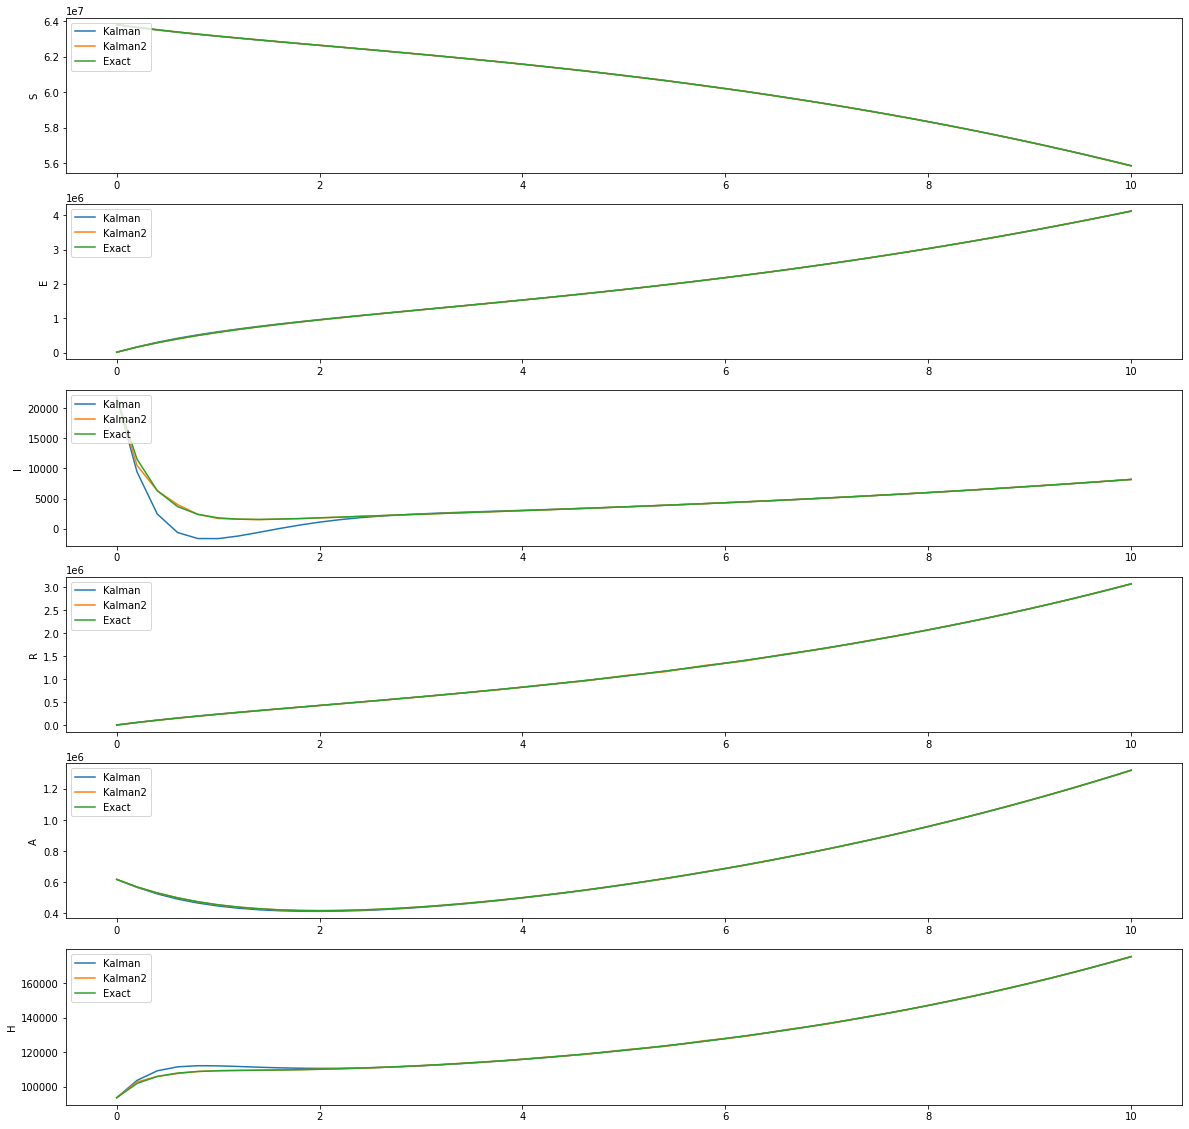

In [45]:
import matplotlib.pyplot as plt
_, axs = plt.subplots(n_obs, 1, figsize=(20, 20))
ylabel = ['S', 'E', 'I', 'R', 'A', 'H']
for i in range(n_obs):
    axs[i].plot(tseq,sim1[:,i, 0], label="Kalman")
    axs[i].plot(tseq,sim2[:,i, 0], label="Kalman2")
    #axs[i].plot(tseq, knum_sim[:, n_deriv_prior[0]*i], label="Kalman2")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [320]:
def ode_fun_jax(x, t, theta=None):
    return jnp.array([[jnp.sin(2*t) - x[0, 0]]])

def ode_fun(x_t, t, theta=None):
    return np.array([x_t[1], np.sin(2*t) - x_t[0]])

# problem setup and intialization
n_deriv = 2  # Total state
n_obs = 1  # Total measures
n_deriv_prior = 4

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 4
tmin = 0.
tmax = 2.

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = 10e-100

# Initial value, x0, for the IVP
W_block = jnp.array([[[0.0, 0.0, 1.0, 0.0]]])

# Initial x0 for odeint
ode0 = jnp.array([-1., 0.])

# Initial x0 for jax block
x0_block = jnp.array([[-1., 0., 1., 2.]])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
n_order = jnp.array([n_deriv_prior]*n_obs)
sigma = jnp.array([sigma]*n_obs)
ode_init = ibm_init(dt, n_order, sigma)

# Jit solver
key = jax.random.PRNGKey(0)
sim_jit = jax.jit(solve_sim, static_argnums=(1, 6))
sim1 = sim_jit(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=None,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **ode_init)
# odeint
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(ode_fun, ode0, tseq)

In [318]:
Y

array([[[0.70427906]],

       [[1.47910373]],

       [[1.70464813]],

       [[1.06762869]]])

In [317]:
exact

array([[-1.        ,  0.        ],
       [-0.83845585,  0.70427906],
       [-0.28242079,  1.47910373],
       [ 0.54721944,  1.70464813],
       [ 1.27461263,  1.06762869]])

In [321]:
n_res = 1
Omega = 0*jnp.ones((1,1,1))
Y = jnp.reshape(exact[n_res::n_res, 1], newshape=(-1, 1, 1))
WW = np.zeros((n_obs, 1, n_deriv_prior))
WW[:, :, 1] = 1

WW = jnp.array(WW)
bridge_init = ibm_bridge_init(n_res, dt, n_order, sigma, Y, WW, Omega)

In [322]:
key = jax.random.PRNGKey(0)
sim_jit2 = jax.jit(bsol.solve_mv, static_argnums=(1, 6))
sim2, _ = sim_jit2(key=key, fun=ode_fun_jax,
        x0=x0_block, theta=None,
        tmin=tmin, tmax=tmax, n_eval=n_eval,
        wgt_meas=W_block, **bridge_init)

In [323]:
sim2

DeviceArray([[[-1.        ,  0.        ,  1.        ,  2.        ]],

             [[-0.83883924,  0.70427906,  1.719871  ,  0.96425759]],

             [[-0.28028005,  1.47910373,  1.17952432, -1.72762171]],

             [[ 0.55015753,  1.70464813, -0.42763008, -3.72445055]],

             [[ 1.27729348,  1.06762869, -2.07666506, -3.14831293]]],            dtype=float64)

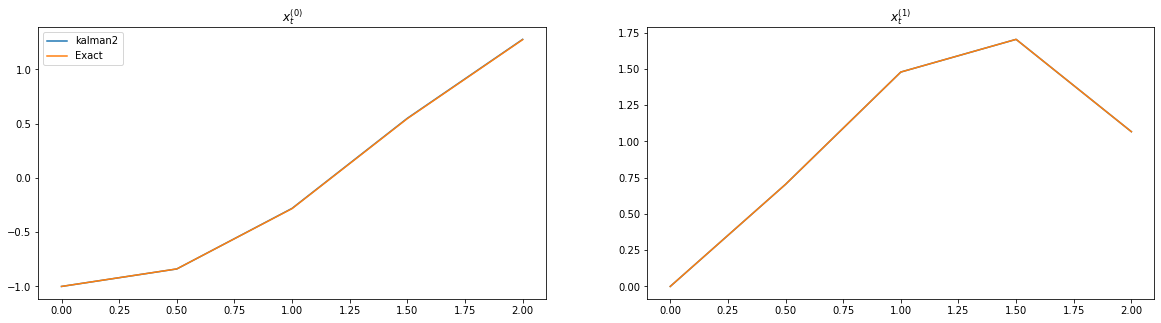

In [325]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
#axs[0].plot(tseq, sim1[:,0, 0], label='kalman')
axs[0].plot(tseq, sim2[:,0, 0], label='kalman2')
axs[0].plot(tseq, exact[:, 0], label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
#axs[1].plot(tseq, sim1[:,0, 1], label='kalman')
axs[1].plot(tseq, sim2[:,0,1], label='kalman')

axs[1].plot(tseq, exact[:, 1], label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()